In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import matplotlib.animation as animation
import random
from Helper.ImportDatasets import df_epsilon, df_epsilon_crit
from Method.calculate_distribution_a import distribution_a

# Introduction
In this notebook we check how well our method performs

In [117]:
"""
We pick sigma, delta, network and number of samples. Although delta doesn't matter much as the region of a we use is large enough to quickly find a solution where prob = 1
"""
def run(network, ani = False, shuffle = False, step_size_a = 0.001, sigma = 0.05, n_samples = 1000, n_a_samples = 100, uncertainty = 0.001, metrics = False):
    delta = 0.05
    
    # Get the network and test set, then split the images
    df_for_network = df_epsilon[df_epsilon['network'] == network]
    df_for_network = df_for_network[df_for_network['ds'] == 'test']
    df_per_image = [df_for_network[df_for_network['image'] == i] for i in df_for_network['image'].unique()]
    
    # We find the distribution of 'a' for the following bins, number represents left side of bin
    a = torch.arange(step_size_a,0.4,step_size_a)
    
    # We keep track of the distributions of 'a' and its max probability
    distributions_of_a = []
    
    # We keep track of what bins of 'a' we use
    a_bins = []
    
    # Initialize D (dataset) and the default value to put in if we don't find elligible epsilons
    D = torch.tensor([[],[]],dtype=torch.float32)
    default = torch.tensor([[0],[0.4]],dtype=torch.float32)
    
    if shuffle:
        random.shuffle(df_per_image)
    
    for i,image in enumerate(df_per_image):
        # We put in the default value first and then change it to the lower and upper bound of the image
        D = torch.cat((D,default),dim=1)
        
        # unsat means epsilon >, thus lower bound
        lower_bound = np.max(image[image['result']=='unsat']['epsilon'].values, initial = default[0,-1])
        # sat means epsilon <, thus upper bound
        upper_bound = np.min(image[image['result']=='sat']['epsilon'].values, initial = default[1,-1])
        D[0,-1] = lower_bound
        D[1,-1] = upper_bound
        
        print(f"image {i+1}")
        
        # Sample in our bins of 'a', 100 samples are taken per bin
        a_samples = torch.rand(n_a_samples,*a.shape)*step_size_a+a
        # We calculate the distribution of each sample
        distr = distribution_a(a_samples,D,sigma,n_samples)
        max_distr = torch.max(distr)
        distributions_of_a.append(distr)
        a_bins.append(a)
        
        # If the distribution of 'a' becomes too peaked to fit in the range of a that has been given we are also satisfied as we know 'a' is in a small enough region
        if torch.isnan(max_distr):
           distributions_of_a.pop()
           a_bins.pop()
           print('found: region is too small')
           break
        
        # We adapt the area in which we search for 'a' based on the distribution
        indices = torch.where(distr != 0)[0]
        left_bound_ind = torch.min(indices)
        right_bound_ind = torch.max(indices)
        
        # We update the bounds
        left_bound = a[left_bound_ind]
        right_bound = a[right_bound_ind]
        
        # We check if the required uncertainty has been reached
        if right_bound-left_bound < 2*uncertainty:
            print('found: uncertainty reached')
            break
        
        # We check if we have attained a probability of at least 1-delta
        if max_distr > 1-delta:
            print('found')
            break
        
        # We update the range of 'a' we search in
        step_size_a = (right_bound-left_bound)/200
        a = torch.arange(left_bound,right_bound,step_size_a)
    
    if metrics:
        quantile, lower_confidence, upper_confidence = get_quantile(network, sigma)
        final_distribution = distributions_of_a[-1]
        final_bins = a_bins[-1]
        metric_1_point, metric_2_point, metric_3_point, metric_4_point = get_metrics(final_distribution, final_bins, quantile, quantile-0.002) # -0.002 as the bins are size 0.002 and the value is the right side of the bin
        metric_1_conf, metric_2_conf, metric_3_conf, metric_4_conf = get_metrics(final_distribution, final_bins, upper_confidence, lower_confidence-0.002)
        
        # make plots
        # fig, ax = plt.subplots()
        # ax.scatter(final_bins, final_distribution)
        # ax.axvline(quantile, color='r')
        # ax.axvline(quantile-0.002, color='g')
        
    
    if ani:
        fig, ax = plt.subplots()
    
        ax.set_ylim(0, 0.1)
        ax.set_xlim(0,0.2)
        line, = ax.plot(a, np.tile(0,len(a)))
        
        
        def animate(i):
            line.set_ydata(distributions_of_a[i])  # update the data.
            line.set_xdata(a_bins[i])
            return line,
        
        
        ani = animation.FuncAnimation(
            fig, animate, frames=len(distributions_of_a), interval=20, blit=True, save_count=50)
        
        # To save the animation, use e.g.
        #
        ani.save(network+".gif")
    
    if metrics:
        return distributions_of_a, a_bins, metric_1_point, metric_2_point, metric_3_point, metric_4_point, metric_1_conf, metric_2_conf, metric_3_conf, metric_4_conf
    else:
        return distributions_of_a, a_bins

In [118]:
networks = df_epsilon['network'].unique()

In [119]:
# save metrics
metrics_point = []
metrics_conf = []

# save final distributions and bins
distrs = []

i=0
for network in networks:
    i+=1
    print(f"network {i}: {network}")
    for runs in range(10):
        print(f"run {runs+1}")
        distr, a_bins, metric_1_point, metric_2_point, metric_3_point, metric_4_point, metric_1_conf, metric_2_conf, metric_3_conf, metric_4_conf = run(network, metrics=True)
        metrics_point.append([network, metric_1_point, metric_2_point, metric_3_point, metric_4_point, runs])
        metrics_conf.append([network, metric_1_conf, metric_2_conf, metric_3_conf, metric_4_conf, runs])
        distrs.append([network, a_bins[-1], distr[-1], runs])

# convert to pandas dataframe
metrics_point = pd.DataFrame(metrics_point, columns=['network', 'metric_1', 'metric_2', 'metric_3', 'metric_4', 'run'])
metrics_conf = pd.DataFrame(metrics_conf, columns=['network', 'metric_1', 'metric_2', 'metric_3', 'metric_4', 'run'])

# Put the distribution with the bins in  adataframe
distrs = pd.DataFrame(distrs, columns=['network', 'bins', 'distribution', 'run'])

# save to csv
metrics_point.to_csv('metrics_point.csv')
metrics_conf.to_csv('metrics_conf.csv')
distrs.to_csv('distributions.csv')
    

network 1: mnist-net
run 1
image 1
image 2
image 3
image 4
image 5
image 6
image 7
image 8
image 9
image 10
image 11
image 12
image 13
image 14
image 15
image 16
image 17
image 18
image 19
image 20
image 21
image 22
image 23
image 24
image 25
image 26
image 27
found: region is too small
run 2
image 1
image 2
image 3
image 4
image 5
image 6
image 7
image 8
image 9
image 10
image 11
image 12
image 13
image 14
image 15
image 16
image 17
image 18
image 19
image 20
image 21
image 22
image 23
image 24
image 25
image 26
image 27
found: region is too small
run 3
image 1
image 2
image 3
image 4
image 5
image 6
image 7
image 8
image 9
image 10
image 11
image 12
image 13
image 14
image 15
image 16
image 17
image 18
image 19
image 20
image 21
image 22
image 23
image 24
image 25
image 26
image 27
found: region is too small
run 4
image 1
image 2
image 3
image 4
image 5
image 6
image 7
image 8
image 9
image 10
image 11
image 12
image 13
image 14
image 15
image 16
image 17
image 18
image 19
image 20
i

In [133]:
distrs[distrs['network'] == network]['bins'].iloc[0]

tensor([0.0036, 0.0036, 0.0037, 0.0037, 0.0038, 0.0038, 0.0039, 0.0039, 0.0040,
        0.0041, 0.0041, 0.0042, 0.0042, 0.0043, 0.0043, 0.0044, 0.0044, 0.0045,
        0.0046, 0.0046, 0.0047, 0.0047, 0.0048, 0.0048, 0.0049, 0.0049, 0.0050,
        0.0051, 0.0051, 0.0052, 0.0052, 0.0053, 0.0053, 0.0054, 0.0054, 0.0055,
        0.0056, 0.0056, 0.0057, 0.0057, 0.0058, 0.0058, 0.0059, 0.0060, 0.0060,
        0.0061, 0.0061, 0.0062, 0.0062, 0.0063, 0.0063, 0.0064, 0.0065, 0.0065,
        0.0066, 0.0066, 0.0067, 0.0067, 0.0068, 0.0068, 0.0069, 0.0070, 0.0070,
        0.0071, 0.0071, 0.0072, 0.0072, 0.0073, 0.0073, 0.0074, 0.0075, 0.0075,
        0.0076, 0.0076, 0.0077, 0.0077, 0.0078, 0.0078, 0.0079, 0.0080, 0.0080,
        0.0081, 0.0081, 0.0082, 0.0082, 0.0083, 0.0084, 0.0084, 0.0085, 0.0085,
        0.0086, 0.0086, 0.0087, 0.0087, 0.0088, 0.0089, 0.0089, 0.0090, 0.0090,
        0.0091, 0.0091, 0.0092, 0.0092, 0.0093, 0.0094, 0.0094, 0.0095, 0.0095,
        0.0096, 0.0096, 0.0097, 0.0097, 

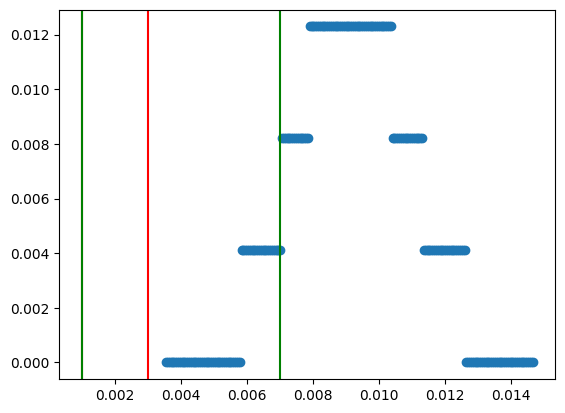

In [135]:
network = "mnist_nn"
run_ = 1
final_bins = distrs[distrs['network'] == network]['bins'].iloc[run_]
final_distribution = distrs[distrs['network'] == network]['distribution'].iloc[run_]

quantile, lower, upper = get_quantile(network, 0.05)

#make plots
fig, ax = plt.subplots()
ax.scatter(final_bins, final_distribution)
ax.axvline(quantile, color='r')
ax.axvline(quantile-0.002, color='r')
ax.axvline(lower, color='g')
ax.axvline(upper, color='g')

In [109]:
f

In [110]:
final_bins

tensor([0.0057, 0.0058, 0.0059, 0.0060, 0.0061, 0.0062, 0.0063, 0.0064, 0.0065,
        0.0066, 0.0066, 0.0067, 0.0068, 0.0069, 0.0070, 0.0071, 0.0072, 0.0073,
        0.0074, 0.0074, 0.0075, 0.0076, 0.0077, 0.0078, 0.0079, 0.0080, 0.0081,
        0.0082, 0.0083, 0.0083, 0.0084, 0.0085, 0.0086, 0.0087, 0.0088, 0.0089,
        0.0090, 0.0091, 0.0091, 0.0092, 0.0093, 0.0094, 0.0095, 0.0096, 0.0097,
        0.0098, 0.0099, 0.0100, 0.0100, 0.0101, 0.0102, 0.0103, 0.0104, 0.0105,
        0.0106, 0.0107, 0.0108, 0.0108, 0.0109, 0.0110, 0.0111, 0.0112, 0.0113,
        0.0114, 0.0115, 0.0116, 0.0117, 0.0117, 0.0118, 0.0119, 0.0120, 0.0121,
        0.0122, 0.0123, 0.0124, 0.0125, 0.0125, 0.0126, 0.0127, 0.0128, 0.0129,
        0.0130, 0.0131, 0.0132, 0.0133, 0.0134, 0.0134, 0.0135, 0.0136, 0.0137,
        0.0138, 0.0139, 0.0140, 0.0141, 0.0142, 0.0142, 0.0143, 0.0144, 0.0145,
        0.0146, 0.0147, 0.0148, 0.0149, 0.0150, 0.0151, 0.0151, 0.0152, 0.0153,
        0.0154, 0.0155, 0.0156, 0.0157, 

# Evaluating metric

In [4]:
networks = df_epsilon['network'].unique()
print(networks)

['mnist-net' 'mnist-net_256x2' 'mnist-net_256x4' 'mnist-net_256x6'
 'mnist_nn' 'mnist_relu_3_100' 'mnist_relu_3_50' 'mnist_relu_4_1024'
 'mnist_relu_6_100' 'mnist_relu_6_200' 'mnist_relu_9_100'
 'mnist_relu_9_200']


In [330]:
sigma = 0.05
quantile_per_network = []

for network in networks:
    # Take all critical epsilons of the test set and put into numpy array
    df_for_network = df_epsilon_crit[df_epsilon_crit['network'] == network]
    df_for_network = df_for_network[df_for_network['ds'] == 'test']
    crit_epsilons = df_for_network['Epsilon'].to_numpy()
    
    # We sort the critical epsilons
    # We use the order statistics to estimate the sigma quantile
    index = int(len(crit_epsilons)*sigma)+1 # As given by David et al. 1986
    quantile_per_network.append(np.sort(crit_epsilons)[index])

In [78]:
from scipy.special import comb
# get confidence interval with binomial distribution
# not very efficient #TODO
def binomial(n,p,x):
    # n = number of trials
    # p = probability of success, value of a (quantile)
    # x = number of successes
    # returns probability of x successes
    
    return comb(n,x)*(p**x)*((1-p)**(n-x))
    

def binomial_bounds(n, p, alpha):
    # n = number of trials
    # p = probability of success, value of a (quantile)
    # alpha = confidence interval
    # returns lower and upper bound of confidence interval
    probs = np.arange(0,n+1)
    probs = binomial(n,p,probs)
    
    # take sum of probabilities until we reach alpha/2
    cumulated_probs = np.cumsum(probs)
    lower_index = np.where(cumulated_probs <= alpha/2)[0][-1]+1
    upper_index = np.where(cumulated_probs >= 1-alpha/2)[0][0]
    
    return lower_index, upper_index

In [79]:
def get_quantile(network, sigma):
    # Take all critical epsilons of the test set and put into numpy array
    df_for_network = df_epsilon_crit[df_epsilon_crit['network'] == network]
    df_for_network = df_for_network[df_for_network['ds'] == 'test']
    crit_epsilons = df_for_network['Epsilon'].to_numpy()
    n = len(crit_epsilons)
    
    # We sort the critical epsilons
    order_statistics = np.sort(crit_epsilons)
    # We use the order statistics to estimate the sigma quantile
    index = int(n*sigma)+1 # As given by David et al. 1986
    lower_index, upper_index = binomial_bounds(n, sigma, 0.05)
    return order_statistics[index], order_statistics[lower_index], order_statistics[upper_index]

In [80]:
def get_metrics(final_distribution, a_bins, upper_confidence, lower_confidence):
    bin_size = a_bins[1] - a_bins[0]
    
    
    # Metric 1, binary
    lower_bound_area = a_bins[torch.where(final_distribution != 0)][0]
    upper_bound_area = a_bins[torch.where(final_distribution != 0)][-1]+bin_size
    
    if lower_bound_area < upper_confidence <= upper_bound_area:
        metric_1 = 1
    elif lower_bound_area <= lower_confidence < upper_bound_area:
        metric_1 = 1
    elif lower_confidence <= lower_bound_area and upper_confidence >= upper_bound_area:
        metric_1 = 1
    else:
        metric_1 = 0
    
    # Metric 2, probability given to the area
    if metric_1 == 1:
        lower_bound_index = torch.where(a_bins >= lower_confidence)[0] 
        lower_bound_index = lower_bound_index[0]
        
        upper_bound_index = torch.where(a_bins + bin_size <= upper_confidence)[0] # we don't include bins who's right side is larger than the quantile
        upper_bound_index = upper_bound_index[-1]
        
        metric_2 = torch.sum(final_distribution[lower_bound_index:upper_bound_index+1]).item()
        
    else:
        metric_2 = 0
    
    # Metric 3, distance to P_max
    indices = torch.where(final_distribution == torch.max(final_distribution))
    Pmax = torch.mean(a_bins[indices]) + bin_size # we take the right side of the bin
    if lower_confidence <= Pmax <= upper_confidence:
        metric_3 = 0
    else:
        metric_3 = torch.min(torch.abs(Pmax - upper_confidence), torch.abs(Pmax - lower_confidence)).item()
    
    # Metric 4, width
    metric_4 = (upper_bound_area - lower_bound_area).item()
    
    return metric_1, metric_2, metric_3, metric_4

In [300]:
left_bound = 0.024
right_bound = 0.026

step_size_a = (right_bound-left_bound)/10
a = torch.arange(left_bound,right_bound,step_size_a)

dummy = torch.zeros(len(a))
dummy[2] = 0.1/2
dummy[3:6] = 0.1

quantile = 0.025+0.002

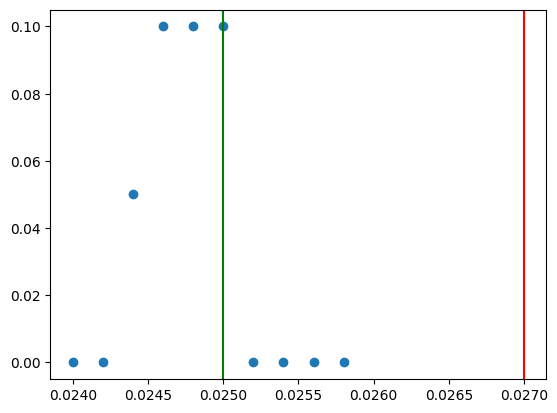

In [302]:
plt.scatter(a,dummy)
plt.axvline(quantile, color='r')
plt.axvline(quantile-0.002, color='g')

In [303]:
metrics(dummy, a, quantile)

tensor(5) tensor(9)


(1, tensor(0.1000), 0, tensor(0.0008))